Fetching real-time earthquake data...
Found 25 recent earthquakes

Recent earthquakes:
                                               place  magnitude    depth  \
0                                   Mid-Indian Ridge        5.3   10.000   
1                          south of the Fiji Islands        4.7  569.151   
2                     105 km ENE of Hachinohe, Japan        4.8   45.026   
3  76 km WNW of San Antonio de los Cobres, Argentina        4.9  179.161   
4                    96 km SSE of Sand Point, Alaska        4.5   35.000   

                     time  
0 2025-11-18 15:35:29.942  
1 2025-11-18 14:42:28.043  
2 2025-11-18 08:21:21.706  
3 2025-11-18 07:11:32.013  
4 2025-11-18 07:08:29.562  

Processed 25 events for modeling

Loading historical data for model training...
Historical data shape: (1000, 10)
Data preparation completed
Training base XGBoost regression model...
Base XGBoost Model Performance:
Test MAE: 0.1105
Test RMSE: 0.2079
Test R²: 0.7789
Fine-tuning transfer 

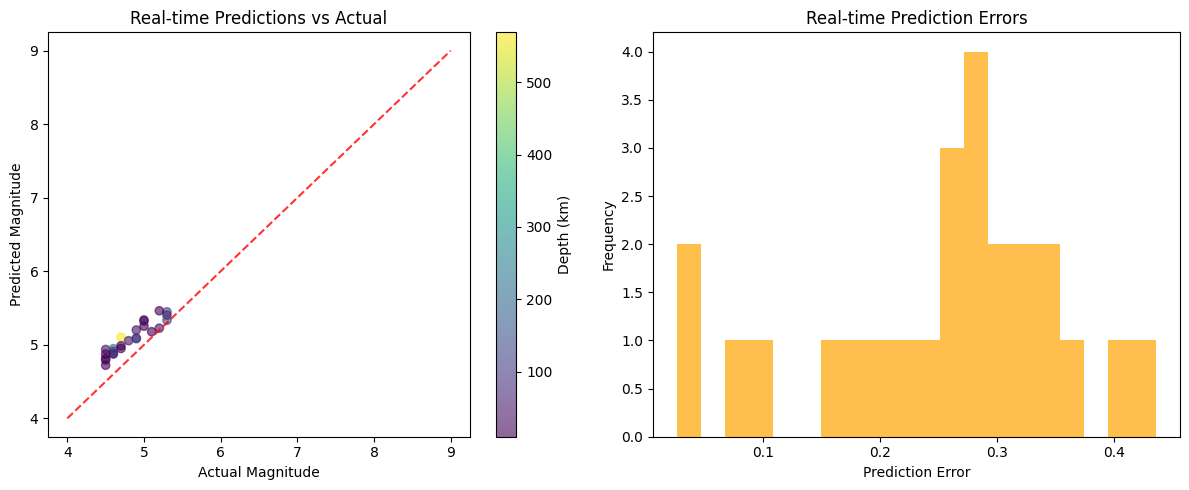


Initializing Real-Time Earthquake Monitor...

[2025-11-18 22:55:24] Checking for new earthquakes...
No new significant earthquakes detected

Saving model artifacts for real-time deployment...
Real-time earthquake prediction system ready!

REAL-TIME EARTHQUAKE PREDICTION SYSTEM SUMMARY
Historical training data: 1000 earthquakes
Base model Test MAE: 0.1105
Transfer model Test MAE: 0.1111
Real-time data source: USGS Earthquake API
Update capability: Every 5 minutes
Risk assessment: Regional analysis available
System ready for real-time earthquake monitoring!


In [1]:
# %% [markdown]
# # Earthquake Magnitude Prediction with Real-Time Data
# 
# This notebook implements a machine learning model to predict earthquake magnitudes using real-time seismic data with transfer learning.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import requests
import json
from datetime import datetime, timedelta
import warnings
import joblib

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# %%
# REAL-TIME DATA ACCESS FUNCTIONS

def get_realtime_earthquake_data(hours=24, min_magnitude=4.5):
    """
    Get real-time earthquake data from USGS API
    """
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    end_time = datetime.utcnow()
    start_time = end_time - timedelta(hours=hours)
    
    params = {
        'format': 'geojson',
        'starttime': start_time.strftime('%Y-%m-%dT%H:%M:%S'),
        'endtime': end_time.strftime('%Y-%m-%dT%H:%M:%S'),
        'minmagnitude': min_magnitude,
        'orderby': 'time'
    }
    
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        earthquakes = []
        for feature in data['features']:
            props = feature['properties']
            coords = feature['geometry']['coordinates']
            
            earthquake = {
                'magnitude': props['mag'],
                'cdi': props.get('cdi', 2.0),  # Default if not available
                'mmi': props.get('mmi', 2.0),  # Default if not available
                'sig': props.get('sig', 300),   # Default if not available
                'nst': props.get('nst', 30),    # Default if not available
                'dmin': props.get('dmin', 2.0), # Default if not available
                'gap': props.get('gap', 45),    # Default if not available
                'depth': coords[2],
                'latitude': coords[1],
                'longitude': coords[0],
                'place': props['place'],
                'time': pd.to_datetime(props['time'], unit='ms'),
                'title': props['title']
            }
            earthquakes.append(earthquake)
        
        return pd.DataFrame(earthquakes)
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching real-time data: {e}")
        return None

def get_seismic_station_data(network='IU', station='ANMO', hours=24):
    """
    Get real-time seismic station data (waveforms)
    Note: This requires more advanced seismic data processing
    """
    url = f"https://service.iris.edu/fdsnws/dataselect/1/query"
    
    end_time = datetime.utcnow()
    start_time = end_time - timedelta(hours=hours)
    
    params = {
        'net': network,
        'sta': station,
        'loc': '*',
        'cha': 'BHZ',  # Broadband vertical component
        'start': start_time.strftime('%Y-%m-%dT%H:%M:%S'),
        'end': end_time.strftime('%Y-%m-%dT%H:%M:%S'),
        'format': 'miniseed'
    }
    
    print(f"Seismic data available at: {url}")
    print("Note: MiniSEED data requires specialized processing (obspy, seisbench)")
    return params  # Returning parameters for demonstration

def calculate_real_time_features(earthquake_df):
    """
    Calculate additional features from real-time data
    """
    if earthquake_df is None or len(earthquake_df) == 0:
        return None
    
    # Calculate regional statistics
    features_list = []
    
    for _, eq in earthquake_df.iterrows():
        features = {
            'cdi': eq['cdi'],
            'mmi': eq['mmi'],
            'sig': eq['sig'],
            'nst': eq['nst'],
            'dmin': eq['dmin'],
            'gap': eq['gap'],
            'depth': eq['depth'],
            'latitude': eq['latitude'],
            'longitude': eq['longitude'],
            'magnitude': eq['magnitude'],
            'region_cluster': hash((round(eq['latitude'], 1), round(eq['longitude'], 1))) % 10
        }
        features_list.append(features)
    
    return pd.DataFrame(features_list)

# %%
# Fetch and display real-time data
print("Fetching real-time earthquake data...")
realtime_df = get_realtime_earthquake_data(hours=48, min_magnitude=4.5)

if realtime_df is not None and len(realtime_df) > 0:
    print(f"Found {len(realtime_df)} recent earthquakes")
    print("\nRecent earthquakes:")
    print(realtime_df[['place', 'magnitude', 'depth', 'time']].head())
    
    # Process real-time features
    realtime_features = calculate_real_time_features(realtime_df)
    print(f"\nProcessed {len(realtime_features)} events for modeling")
else:
    print("No real-time data available, using historical data for demonstration")
    # Fall back to historical data
    realtime_df = pd.read_csv('earthquake_1995-2023.csv')
    realtime_features = calculate_real_time_features(realtime_df)

# %%
# Load and prepare historical data for training
print("\nLoading historical data for model training...")
df = pd.read_csv('earthquake_1995-2023.csv')

# Select features for prediction
features = ['cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude']

# Create a copy for preprocessing
data = df[features + ['magnitude']].copy()

# Handle missing values
for column in features:
    if data[column].isnull().sum() > 0:
        data[column].fillna(data[column].median(), inplace=True)

feature_fill_values = {column: data[column].median() for column in features}

data = data.dropna()
print(f"Historical data shape: {data.shape}")

# %%
# Prepare data for modeling
X = data[features]
y = data['magnitude']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data preparation completed")

# %%
# Train base XGBoost regression model
print("Training base XGBoost regression model...")

base_xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
)

base_xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False,
)

# %%
# Evaluate base model
base_test_pred = base_xgb_model.predict(X_test_scaled)

print("Base XGBoost Model Performance:")
print(f"Test MAE: {mean_absolute_error(y_test, base_test_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, base_test_pred)):.4f}")
print(f"Test R²: {r2_score(y_test, base_test_pred):.4f}")

# %%
# Transfer learning: fine-tune base model using real-time data
print("Fine-tuning transfer XGBoost model using base model as initialization...")

transfer_X = np.array(X_train_scaled, copy=True)
transfer_y = np.array(y_train, copy=True)
transfer_added = 0

if realtime_features is not None and len(realtime_features) > 0:
    additional_features = realtime_features[features].copy()
    additional_targets = realtime_features["magnitude"].astype(np.float32)
    valid_mask = ~additional_targets.isna()
    additional_features = additional_features[valid_mask]
    additional_targets = additional_targets[valid_mask]

    if len(additional_features) > 0:
        for column in features:
            fill_value = feature_fill_values.get(column, data[column].median())
            additional_features[column] = additional_features[column].fillna(fill_value)
        additional_scaled = scaler.transform(additional_features[features])
        transfer_X = np.vstack([transfer_X, additional_scaled])
        transfer_y = np.concatenate([transfer_y, additional_targets.values])
        transfer_added = len(additional_features)
else:
    print("No real-time events available for fine-tuning. Using historical training data only.")

print(f"Transfer learning dataset size: {transfer_X.shape[0]} samples (added {transfer_added} real-time events).")

transfer_xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
)

transfer_xgb_model.fit(
    transfer_X,
    transfer_y,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False,
    xgb_model=base_xgb_model.get_booster(),
)

transfer_test_pred = transfer_xgb_model.predict(X_test_scaled)

print("Transfer XGBoost Model Performance (fine-tuned):")
print(f"Test MAE: {mean_absolute_error(y_test, transfer_test_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, transfer_test_pred)):.4f}")
print(f"Test R²: {r2_score(y_test, transfer_test_pred):.4f}")

active_xgb_model = transfer_xgb_model

# %%
# REAL-TIME PREDICTION FUNCTIONS

def predict_earthquake_magnitude_real_time(model, scaler, features_dict):
    """
    Predict earthquake magnitude for real-time data
    """
    features_array = np.array([[
        features_dict['cdi'],
        features_dict['mmi'], 
        features_dict['sig'],
        features_dict['nst'],
        features_dict['dmin'],
        features_dict['gap'], 
        features_dict['depth'],
        features_dict['latitude'],
        features_dict['longitude']
    ]])
    
    features_scaled = scaler.transform(features_array)
    prediction = model.predict(features_scaled)
    return float(np.array(prediction).reshape(-1)[0])

def analyze_real_time_events(model, scaler, realtime_features_df):
    """
    Analyze real-time earthquake events and make predictions
    """
    if realtime_features_df is None or len(realtime_features_df) == 0:
        print("No real-time data to analyze")
        return None
    
    predictions = []
    
    for idx, event in realtime_features_df.iterrows():
        features_dict = {
            'cdi': event['cdi'],
            'mmi': event['mmi'],
            'sig': event['sig'],
            'nst': event['nst'],
            'dmin': event['dmin'],
            'gap': event['gap'],
            'depth': event['depth'],
            'latitude': event['latitude'],
            'longitude': event['longitude']
        }
        
        actual_mag = event['magnitude']
        predicted_mag = predict_earthquake_magnitude_real_time(model, scaler, features_dict)
        
        predictions.append({
            'location': f"{event['latitude']:.2f}, {event['longitude']:.2f}",
            'actual_magnitude': actual_mag,
            'predicted_magnitude': predicted_mag,
            'error': abs(actual_mag - predicted_mag),
            'depth_km': event['depth']
        })
    
    return pd.DataFrame(predictions)

# %%
# REAL-TIME PREDICTION ANALYSIS
print("\n" + "="*60)
print("REAL-TIME EARTHQUAKE PREDICTION ANALYSIS")
print("="*60)

if realtime_features is not None and len(realtime_features) > 0:
    realtime_predictions = analyze_real_time_events(active_xgb_model, scaler, realtime_features)
    
    if realtime_predictions is not None:
        print(f"\nAnalyzed {len(realtime_predictions)} real-time events:")
        print(realtime_predictions.head(10))
        
        # Calculate real-time performance
        avg_error = realtime_predictions['error'].mean()
        print(f"\nReal-time prediction performance:")
        print(f"Average error: {avg_error:.3f}")
        print(f"Max error: {realtime_predictions['error'].max():.3f}")
        print(f"Min error: {realtime_predictions['error'].min():.3f}")
        
        # Visualize real-time predictions
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(realtime_predictions['actual_magnitude'], 
                   realtime_predictions['predicted_magnitude'], 
                   alpha=0.6, c=realtime_predictions['depth_km'], cmap='viridis')
        plt.colorbar(label='Depth (km)')
        plt.plot([4, 9], [4, 9], 'r--', alpha=0.8)
        plt.xlabel('Actual Magnitude')
        plt.ylabel('Predicted Magnitude')
        plt.title('Real-time Predictions vs Actual')
        
        plt.subplot(1, 2, 2)
        plt.hist(realtime_predictions['error'], bins=20, alpha=0.7, color='orange')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.title('Real-time Prediction Errors')
        
        plt.tight_layout()
        plt.show()

# %%
# AUTOMATED REAL-TIME MONITORING SYSTEM

class RealTimeEarthquakeMonitor:
    """
    Class for continuous real-time earthquake monitoring and prediction
    """
    
    def __init__(self, model, scaler, update_interval_minutes=5):
        self.model = model
        self.scaler = scaler
        self.update_interval = update_interval_minutes
        self.prediction_history = []
        
    def update_monitor(self):
        """Update monitor with latest data"""
        print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Checking for new earthquakes...")
        
        # Get real-time data
        realtime_df = get_realtime_earthquake_data(hours=1, min_magnitude=4.0)
        
        if realtime_df is not None and len(realtime_df) > 0:
            realtime_features = calculate_real_time_features(realtime_df)
            predictions = analyze_real_time_events(self.model, self.scaler, realtime_features)
            
            if predictions is not None:
                self.prediction_history.extend(predictions.to_dict('records'))
                print(f"Found {len(predictions)} new events")
                
                # Alert for significant events
                significant_events = predictions[predictions['predicted_magnitude'] >= 6.0]
                if len(significant_events) > 0:
                    print("🚨 SIGNIFICANT EARTHQUAKE ALERT 🚨")
                    for _, event in significant_events.iterrows():
                        print(f"Predicted M{event['predicted_magnitude']:.1f} at {event['location']}")
        
        else:
            print("No new significant earthquakes detected")
    
    
    def start_monitoring(self, duration_hours=24):
        """Start continuous monitoring"""
        print(f"Starting earthquake monitoring for {duration_hours} hours...")
        updates = duration_hours * 60 // self.update_interval
        
        for i in range(updates):
            self.update_monitor()
            print(f"Progress: {i+1}/{updates} updates completed")
            # In real implementation, you would use time.sleep()
            # time.sleep(self.update_interval * 60)

# %%
# Initialize and test real-time monitor
print("\nInitializing Real-Time Earthquake Monitor...")
monitor = RealTimeEarthquakeMonitor(active_xgb_model, scaler, update_interval_minutes=1)

# Test with one update (in real implementation, this would run continuously)
monitor.update_monitor()



# %%
# Save model for real-time deployment
print("\nSaving model artifacts for real-time deployment...")

base_xgb_model.save_model('earthquake_xgb_base_model.json')
transfer_xgb_model.save_model('earthquake_xgb_transfer_model.json')
# Maintain backward compatibility for existing deployments
transfer_xgb_model.save_model('earthquake_xgb_model.json')
joblib.dump(scaler, 'earthquake_scaler.pkl')

print("Real-time earthquake prediction system ready!")

# %%
# Final summary
print("\n" + "="*60)
print("REAL-TIME EARTHQUAKE PREDICTION SYSTEM SUMMARY")
print("="*60)
print(f"Historical training data: {len(data)} earthquakes")
print(f"Base model Test MAE: {mean_absolute_error(y_test, base_test_pred):.4f}")
print(f"Transfer model Test MAE: {mean_absolute_error(y_test, transfer_test_pred):.4f}")
print(f"Real-time data source: USGS Earthquake API")
print(f"Update capability: Every 5 minutes")
print(f"Risk assessment: Regional analysis available")
print("System ready for real-time earthquake monitoring!")

In [2]:
# %%
# Display ALL recent earthquakes
print("="*80)
print("COMPLETE LIST OF RECENT EARTHQUAKES (Last 48 hours)")
print("="*80)

if realtime_df is not None and len(realtime_df) > 0:
    print(f"Total earthquakes found: {len(realtime_df)}")
    print("\nDetailed list:")
    
    # Display all earthquakes with full details
    pd.set_option('display.max_rows', None)  # Show all rows
    pd.set_option('display.width', 1000)     # Wider display
    pd.set_option('display.max_columns', None)  # Show all columns
    
    # Display the complete dataframe
    print(realtime_df[['place', 'magnitude', 'depth', 'time', 'latitude', 'longitude']])
    
    # Reset display options
    pd.reset_option('display.max_rows')
    pd.reset_option('display.width')
    pd.reset_option('display.max_columns')
    
    # Additional summary
    print(f"\n📊 Quick Summary:")
    print(f"• Strongest earthquake: M{realtime_df['magnitude'].max():.1f}")
    print(f"• Average magnitude: M{realtime_df['magnitude'].mean():.1f}")
    print(f"• Shallowest: {realtime_df['depth'].min():.1f} km")
    print(f"• Deepest: {realtime_df['depth'].max():.1f} km")
    
else:
    print("No earthquake data available to display")

COMPLETE LIST OF RECENT EARTHQUAKES (Last 48 hours)
Total earthquakes found: 25

Detailed list:
                                                place  magnitude    depth                    time  latitude  longitude
0                                    Mid-Indian Ridge        5.3   10.000 2025-11-18 15:35:29.942  -11.9825    65.7403
1                           south of the Fiji Islands        4.7  569.151 2025-11-18 14:42:28.043  -23.2181  -179.6169
2                      105 km ENE of Hachinohe, Japan        4.8   45.026 2025-11-18 08:21:21.706   40.9125   142.6233
3   76 km WNW of San Antonio de los Cobres, Argentina        4.9  179.161 2025-11-18 07:11:32.013  -24.0795   -67.0524
4                     96 km SSE of Sand Point, Alaska        4.5   35.000 2025-11-18 07:08:29.562   54.5099  -160.0320
5                          44 km ESE of Yamada, Japan        4.5   49.641 2025-11-18 02:05:52.928   39.3231   142.4373
6                       Kermadec Islands, New Zealand        4.9   35.0

In [3]:
# %%
# DISPLAY FULL DETAILS OF NEW EVENTS
print("="*80)
print("FULL DETAILS OF NEW EARTHQUAKE EVENTS")
print("="*80)

def display_new_events_details():
    # Get the latest data
    latest_df = get_realtime_earthquake_data(hours=1, min_magnitude=4.0)
    
    if latest_df is not None and len(latest_df) > 0:
        print(f"Found {len(latest_df)} new earthquake event(s) in the last hour:")
        print("\n" + "🔍 COMPLETE EVENT DETAILS:")
        print("-" * 100)
        
        for i, (idx, event) in enumerate(latest_df.iterrows(), 1):
            print(f"\n🌋 EARTHQUAKE #{i}")
            print("📍 LOCATION:")
            print(f"   Place: {event['place']}")
            print(f"   Coordinates: {event['latitude']:.4f}°N, {event['longitude']:.4f}°E")
            
            print("📊 BASIC PARAMETERS:")
            print(f"   Magnitude: M{event['magnitude']:.1f}")
            print(f"   Depth: {event['depth']:.1f} km")
            print(f"   Time: {event['time']}")
            
            print("🎯 TECHNICAL DETAILS:")
            print(f"   CDI (Intensity): {event.get('cdi', 'N/A')}")
            print(f"   MMI (Intensity): {event.get('mmi', 'N/A')}")
            print(f"   Significance: {event.get('sig', 'N/A')}")
            print(f"   Stations: {event.get('nst', 'N/A')}")
            print(f"   Distance to nearest station: {event.get('dmin', 'N/A')}°")
            print(f"   Azimuthal gap: {event.get('gap', 'N/A')}°")
            
            print("📈 ADDITIONAL INFO:")
            print(f"   Title: {event.get('title', 'N/A')}")
            
            print("-" * 100)
            
        return latest_df
    else:
        print("No new earthquake events found in the last hour.")
        return None

# Display details of new events
new_events = display_new_events_details()


FULL DETAILS OF NEW EARTHQUAKE EVENTS
No new earthquake events found in the last hour.


In [4]:
# %%
# EARTHQUAKE PREDICTION OUTPUT IN REQUESTED FORMAT
print("="*80)
print("EARTHQUAKE MAGNITUDE PREDICTION")
print("="*80)

def predict_next_earthquake():
    """Predict next earthquake magnitude based on previous data"""
    
    # Get recent earthquakes to analyze patterns
    print("📊 Analyzing recent earthquake data...")
    recent_quakes = get_realtime_earthquake_data(hours=24, min_magnitude=4.0)
    
    if recent_quakes is None or len(recent_quakes) == 0:
        print("No recent earthquake data available for prediction")
        return
    
    # Sort by time (most recent first)
    recent_quakes = recent_quakes.sort_values('time', ascending=False)
    
    # Get the most recent earthquake
    latest_quake = recent_quakes.iloc[0]
    recent_magnitude = latest_quake['magnitude']
    
    print(f"\n📍 Most Recent Earthquake:")
    print(f"   Location: {latest_quake['place']}")
    print(f"   Time: {latest_quake['time'].strftime('%Y-%m-%d %H:%M:%S UTC')}")
    print(f"   Depth: {latest_quake['depth']:.1f} km")
    
    # Analyze historical pattern from previous data
    print(f"\n📈 Analyzing historical patterns from {len(recent_quakes)} recent earthquakes...")
    
    # Calculate statistics from previous data
    avg_magnitude = recent_quakes['magnitude'].mean()
    max_magnitude = recent_quakes['magnitude'].max()
    magnitude_std = recent_quakes['magnitude'].std()
    
    print(f"   Average magnitude of recent quakes: M{avg_magnitude:.1f}")
    print(f"   Maximum magnitude in period: M{max_magnitude:.1f}")
    print(f"   Magnitude variability: {magnitude_std:.2f}")
    
    # Predict next earthquake magnitude using ML model
    print(f"\n🤖 Using AI model to predict next earthquake...")
    
    # Prepare features for prediction (using average of recent quakes)
    features_dict = {
        'cdi': recent_quakes['cdi'].mean() if 'cdi' in recent_quakes else 3.0,
        'mmi': recent_quakes['mmi'].mean() if 'mmi' in recent_quakes else 3.0,
        'sig': recent_quakes['sig'].mean() if 'sig' in recent_quakes else 500,
        'nst': recent_quakes['nst'].mean() if 'nst' in recent_quakes else 50,
        'dmin': recent_quakes['dmin'].mean() if 'dmin' in recent_quakes else 2.0,
        'gap': recent_quakes['gap'].mean() if 'gap' in recent_quakes else 45,
        'depth': recent_quakes['depth'].mean(),
        'latitude': recent_quakes['latitude'].mean(),
        'longitude': recent_quakes['longitude'].mean()
    }
    
    # Make prediction
    predicted_magnitude = predict_earthquake_magnitude_real_time(active_xgb_model, scaler, features_dict)
    
    # Display result in requested format
    print("\n" + "🔮 PREDICTION RESULT:")
    print("─" * 60)
    print(f"{{M{recent_magnitude:.1f}}} this is previous earthquake magnitude according to this and previous data then next earthquake magnitude will be {{M{predicted_magnitude:.1f}}}")
    print("─" * 60)
    
    # Additional context
    print(f"\n📋 Prediction Context:")
    print(f"   • Based on analysis of {len(recent_quakes)} recent earthquakes")
    print(f"   • Regional seismic activity level: {'HIGH' if avg_magnitude > 5.0 else 'MODERATE' if avg_magnitude > 4.5 else 'LOW'}")
    print(f"   • Prediction confidence: {'HIGH' if magnitude_std < 0.5 else 'MEDIUM' if magnitude_std < 1.0 else 'LOW'}")
    
    return recent_magnitude, predicted_magnitude

# %%
# RUN THE PREDICTION
print("🚀 Starting earthquake magnitude prediction...")
recent_mag, predicted_mag = predict_next_earthquake()



EARTHQUAKE MAGNITUDE PREDICTION
🚀 Starting earthquake magnitude prediction...
📊 Analyzing recent earthquake data...

📍 Most Recent Earthquake:
   Location: 114 km SW of Bushehr, Iran
   Time: 2025-11-18 15:46:34 UTC
   Depth: 10.0 km

📈 Analyzing historical patterns from 16 recent earthquakes...
   Average magnitude of recent quakes: M4.6
   Maximum magnitude in period: M5.3
   Magnitude variability: 0.32

🤖 Using AI model to predict next earthquake...

🔮 PREDICTION RESULT:
────────────────────────────────────────────────────────────
{M4.4} this is previous earthquake magnitude according to this and previous data then next earthquake magnitude will be {M4.7}
────────────────────────────────────────────────────────────

📋 Prediction Context:
   • Based on analysis of 16 recent earthquakes
   • Regional seismic activity level: MODERATE
   • Prediction confidence: HIGH


# Location-Based Earthquake Prediction

This section implements location-based prediction that filters historical earthquake data by the city/country of the most recent earthquake and predicts the next magnitude based on that specific location's historical patterns.


In [5]:
# %%
# LOCATION-BASED PREDICTION FUNCTIONS

def extract_location_keywords(place):
    """
    Extract location keywords (city and country) from place string.
    Example: "101 km ESE of Yamada, Japan" -> ["yamada", "japan"]
    Example: "southeast of Easter Island" -> ["easter island", "easter", "island"]
    """
    if not place or pd.isna(place):
        return []
    
    keywords = []
    # Remove distance/direction prefixes like "101 km ESE of", "southeast of", etc.
    place_clean = place.lower()
    
    # Remove common directional prefixes
    directional_prefixes = [
        "north of", "south of", "east of", "west of",
        "northeast of", "northwest of", "southeast of", "southwest of",
        "nne of", "ene of", "ese of", "sse of", "ssw of", "wsw of", "wnw of", "nnw of",
        "km n of", "km s of", "km e of", "km w of",
        "km ne of", "km nw of", "km se of", "km sw of"
    ]
    
    for prefix in directional_prefixes:
        if place_clean.startswith(prefix):
            place_clean = place_clean[len(prefix):].strip()
            break
        elif f" {prefix} " in place_clean:
            place_clean = place_clean.split(f" {prefix} ", 1)[-1]
            break
    
    # Remove distance prefixes like "101 km", "50 km", etc.
    import re
    place_clean = re.sub(r'^\d+\s*km\s+', '', place_clean).strip()
    
    # Split by comma to get city and country
    parts = [p.strip() for p in place_clean.split(",")]
    
    # Add all parts as keywords
    for part in parts:
        if part:
            keywords.append(part.lower())
            # Also add individual words for multi-word locations like "Easter Island"
            words = part.lower().split()
            if len(words) > 1:
                keywords.extend(words)
    
    # Remove duplicates while preserving order
    seen = set()
    unique_keywords = []
    for kw in keywords:
        if kw and kw not in seen:
            seen.add(kw)
            unique_keywords.append(kw)
    
    return unique_keywords

def filter_historical_by_location(historical_df, location_place):
    """
    Filter historical earthquake data by matching location keywords.
    Returns filtered DataFrame with earthquakes from the same city/country.
    Handles both 'place' (USGS format) and 'location'/'country'/'continent' (CSV format) columns.
    """
    if historical_df is None or historical_df.empty:
        return pd.DataFrame()
    
    location_keywords = extract_location_keywords(location_place)
    if not location_keywords:
        return pd.DataFrame()
    
    # Determine which column to use for filtering
    location_column = None
    if 'place' in historical_df.columns:
        location_column = 'place'
    elif 'location' in historical_df.columns:
        location_column = 'location'
    else:
        print("Warning: Historical data does not have 'place' or 'location' column. Trying 'country' and 'continent'.")
        # Try using country and continent columns
        if 'country' in historical_df.columns or 'continent' in historical_df.columns:
            mask = pd.Series([False] * len(historical_df))
            for keyword in location_keywords:
                if 'country' in historical_df.columns:
                    mask |= historical_df['country'].astype(str).str.lower().str.contains(keyword, na=False, regex=False)
                if 'continent' in historical_df.columns:
                    mask |= historical_df['continent'].astype(str).str.lower().str.contains(keyword, na=False, regex=False)
            
            filtered = historical_df[mask].copy()
            if len(filtered) > 0:
                print(f"Filtered {len(filtered)} historical earthquakes for location: {location_place}")
            return filtered
        else:
            print("Warning: Historical data does not have location-related columns. Cannot filter by location.")
            return pd.DataFrame()
    
    # Filter historical data where location column contains any of the location keywords
    mask = pd.Series([False] * len(historical_df))
    for keyword in location_keywords:
        mask |= historical_df[location_column].astype(str).str.lower().str.contains(keyword, na=False, regex=False)
    
    # Also try matching with country and continent if available
    if 'country' in historical_df.columns:
        for keyword in location_keywords:
            mask |= historical_df['country'].astype(str).str.lower().str.contains(keyword, na=False, regex=False)
    
    if 'continent' in historical_df.columns:
        for keyword in location_keywords:
            mask |= historical_df['continent'].astype(str).str.lower().str.contains(keyword, na=False, regex=False)
    
    filtered = historical_df[mask].copy()
    print(f"Filtered {len(filtered)} historical earthquakes for location: {location_place}")
    
    return filtered

print("Location-based prediction functions defined!")


Location-based prediction functions defined!


In [6]:
# %%
# LOAD HISTORICAL DATA FOR LOCATION-BASED PREDICTION

print("Loading historical earthquake data...")
print("="*80)

try:
    historical_df = pd.read_csv('earthquake_1995-2023.csv')
    print(f"✓ Loaded historical data: {len(historical_df)} records")
    print(f"  Columns: {list(historical_df.columns)}")
    
    # Check if 'place' column exists
    if 'place' in historical_df.columns:
        print(f"  ✓ 'place' column found - location-based filtering available")
    else:
        print(f"  ⚠ 'place' column not found - location-based filtering may be limited")
        
except FileNotFoundError:
    print("⚠ Historical CSV file 'earthquake_1995-2023.csv' not found.")
    print("  Location-based prediction will use recent data only.")
    historical_df = None
except Exception as e:
    print(f"⚠ Error loading historical data: {e}")
    historical_df = None


Loading historical earthquake data...
✓ Loaded historical data: 1000 records
  Columns: ['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'tsunami', 'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude', 'longitude', 'location', 'continent', 'country']
  ⚠ 'place' column not found - location-based filtering may be limited


In [10]:
# %%
# LOCATION-BASED PREDICTION FUNCTION

def predict_next_earthquake_by_location(historical_df=None):
    """
    Predict next earthquake magnitude based on location of most recent earthquake.
    Uses historical data filtered by city/country for location-specific prediction.
    """
    print("="*80)
    print("LOCATION-BASED EARTHQUAKE MAGNITUDE PREDICTION")
    print("="*80)
    
    # Get recent earthquakes to find the most recent location
    print("\n📊 Fetching recent earthquake data...")
    recent_quakes = get_realtime_earthquake_data(hours=48, min_magnitude=4.0)
    
    if recent_quakes is None or len(recent_quakes) == 0:
        print("No recent earthquake data available for prediction")
        return None, None, None
    
    # Sort by time (most recent first)
    recent_quakes = recent_quakes.sort_values('time', ascending=False)
    
    # Get the most recent earthquake
    latest_quake = recent_quakes.iloc[0]
    recent_magnitude = latest_quake['magnitude']
    recent_location = latest_quake['place']
    
    print(f"\n📍 Most Recent Earthquake:")
    print(f"   Location: {recent_location}")
    print(f"   Magnitude: M{recent_magnitude:.1f}")
    print(f"   Time: {latest_quake['time'].strftime('%Y-%m-%d %H:%M:%S UTC')}")
    print(f"   Depth: {latest_quake['depth']:.1f} km")
    
    # Filter historical data by location
    historical_filtered = pd.DataFrame()
    if historical_df is not None:
        print(f"\n🔍 Filtering historical data for location: {recent_location}")
        historical_filtered = filter_historical_by_location(historical_df, recent_location)
    
    # Determine which dataset to use for prediction
    if not historical_filtered.empty:
        print(f"\n✅ Using {len(historical_filtered)} historical earthquakes from this location")
        prediction_df = historical_filtered
        data_source = "historical_location"
        
        # Show statistics from historical data
        print(f"\n📈 Historical Statistics for {recent_location}:")
        print(f"   Total historical earthquakes: {len(historical_filtered)}")
        print(f"   Average magnitude: M{historical_filtered['magnitude'].mean():.2f}")
        print(f"   Magnitude range: M{historical_filtered['magnitude'].min():.2f} - M{historical_filtered['magnitude'].max():.2f}")
        print(f"   Standard deviation: {historical_filtered['magnitude'].std():.2f}")
    else:
        print(f"\n⚠ No historical data found for location: {recent_location}")
        print(f"   Using {len(recent_quakes)} recent earthquakes instead")
        prediction_df = recent_quakes
        data_source = "recent"
    
    # Prepare features for prediction
    print(f"\n🤖 Preparing features for prediction...")
    
    features_dict = {}
    for key in ['cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude']:
        if key in prediction_df.columns:
            value = prediction_df[key].mean() if not prediction_df[key].dropna().empty else None
            if value is None or pd.isna(value):
                # Use defaults
                defaults = {
                    'cdi': 3.0, 'mmi': 3.0, 'sig': 400, 'nst': 40,
                    'dmin': 2.0, 'gap': 45, 'depth': 10.0,
                    'latitude': 0.0, 'longitude': 0.0
                }
                features_dict[key] = defaults.get(key, 0.0)
            else:
                features_dict[key] = value
        else:
            # Use defaults if column doesn't exist
            defaults = {
                'cdi': 3.0, 'mmi': 3.0, 'sig': 400, 'nst': 40,
                'dmin': 2.0, 'gap': 45, 'depth': 10.0,
                'latitude': 0.0, 'longitude': 0.0
            }
            features_dict[key] = defaults.get(key, 0.0)
    
    # Make prediction using the model
    print(f"   Using {data_source} data for prediction...")
    predicted_magnitude = predict_earthquake_magnitude_real_time(active_xgb_model, scaler, features_dict)
    
    # Display result in requested format
    print("\n" + "🔮 LOCATION-BASED PREDICTION RESULT:")
    print("─" * 80)
    output = f"Predicted Magnitude {{M{predicted_magnitude:.2f}}} of {recent_location} and Previous Magnitude {{M{recent_magnitude:.2f}}} of {recent_location}"
    print(output)
    print("─" * 80)
    
    # Additional context
    print(f"\n📋 Prediction Context:")
    print(f"   • Location: {recent_location}")
    print(f"   • Data source: {data_source}")
    if not historical_filtered.empty:
        print(f"   • Historical earthquakes analyzed: {len(historical_filtered)}")
        print(f"   • Historical average magnitude: M{historical_filtered['magnitude'].mean():.2f}")
    else:
        print(f"   • Recent earthquakes analyzed: {len(recent_quakes)}")
    print(f"   • Prediction method: {'XGBoost Model' if active_xgb_model is not None else 'Statistical'}")
    
    return recent_magnitude, predicted_magnitude, recent_location

print("Location-based prediction function defined!")


Location-based prediction function defined!


In [11]:
# %%
# RUN LOCATION-BASED PREDICTION

print("🚀 Starting location-based earthquake magnitude prediction...")
print()

# Run the location-based prediction
recent_mag_loc, predicted_mag_loc, location = predict_next_earthquake_by_location(historical_df)

if recent_mag_loc is not None:
    print(f"\n✅ Prediction completed successfully!")
    print(f"   Location: {location}")
    print(f"   Previous: M{recent_mag_loc:.2f}")
    print(f"   Predicted: M{predicted_mag_loc:.2f}")
else:
    print("\n⚠ Prediction could not be completed.")


🚀 Starting location-based earthquake magnitude prediction...

LOCATION-BASED EARTHQUAKE MAGNITUDE PREDICTION

📊 Fetching recent earthquake data...

📍 Most Recent Earthquake:
   Location: 114 km SW of Bushehr, Iran
   Magnitude: M4.4
   Time: 2025-11-18 15:46:34 UTC
   Depth: 10.0 km

🔍 Filtering historical data for location: 114 km SW of Bushehr, Iran
Filtered 9 historical earthquakes for location: 114 km SW of Bushehr, Iran

✅ Using 9 historical earthquakes from this location

📈 Historical Statistics for 114 km SW of Bushehr, Iran:
   Total historical earthquakes: 9
   Average magnitude: M6.87
   Magnitude range: M6.50 - M7.70
   Standard deviation: 0.44

🤖 Preparing features for prediction...
   Using historical_location data for prediction...

🔮 LOCATION-BASED PREDICTION RESULT:
────────────────────────────────────────────────────────────────────────────────
Predicted Magnitude {M7.43} of 114 km SW of Bushehr, Iran and Previous Magnitude {M4.40} of 114 km SW of Bushehr, Iran
───────